<a href="https://colab.research.google.com/github/stephan-strate/sentiment-fine-foods/blob/master/dataset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ensure images directory exists
from pathlib import Path
Path("images").mkdir(parents=True, exist_ok=True)

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import urllib.request
import zipfile

TU_GREEN = "#639a00"

url = "https://storage.statc.de/datasets/amazon-fine-food/amazon-fine-food.zip"
filehandle, _ = urllib.request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, "r")
zip_file_object.extractall()

In [3]:
df = pd.read_csv("amazon-fine-food.csv", delimiter=",", header=0)
print("Dataset has {:,} rows".format(df.shape[0]))

Dataset has 568,454 rows


In [4]:
df[["HelpfulnessNumerator", "HelpfulnessDenominator", "Score", "Text"]].sample(5)

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text
164770,0,0,5,Wow does my dog Pie LOVE these treats!! I was ...
37892,0,1,5,I really enjoy this tea and buying it through ...
338052,0,0,5,I've been buying cat treats for many years. Of...
251529,3,3,1,I bought this toor dal from SimplyBeautiful. I...
255322,1,1,5,This has been my go-to coffee for decades. Yes...


In [5]:
import re

df_cleaned = df.copy()

def cleanhtml(series):
  raw_text = series.Text
  cleanr = re.compile("<.*?>")
  clean_text = re.sub(cleanr, " ", raw_text)
  return clean_text

# clean html content of texts
df_cleaned["TextClean"] = df_cleaned.apply(cleanhtml, axis=1)
df_cleaned["Html"] = df_cleaned.apply(lambda x: x.Text != x.TextClean, axis=1)
print("Cleaned {:,} rows from html ({} %)".format(df_cleaned.Html.sum(), round(df_cleaned.Html.sum() / len(df.index) * 100)))

Cleaned 147,324 rows from html (26.0 %)


In [6]:
# removing duplicates
df_cleaned.drop_duplicates(subset=["TextClean", "Score"], inplace=True)
rows_removed = len(df.index) - len(df_cleaned.index)
print("Removed {:,} duplicates ({} %)".format(rows_removed, round(rows_removed / len(df.index) * 100)))

Removed 174,784 duplicates (31 %)


In [7]:
print("Dataset size after cleaning: {:,} / {:,} rows ({} %)".format(len(df_cleaned.index), len(df.index), round(len(df_cleaned.index) / len(df.index) * 100)))

Dataset size after cleaning: 393,670 / 568,454 rows (69 %)


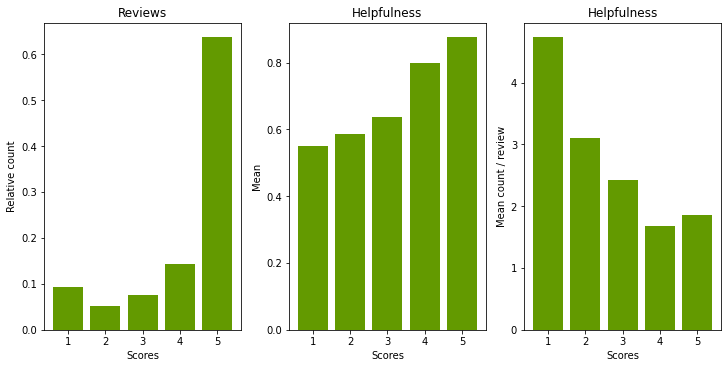

In [8]:
import statistics

label_values = set(df_cleaned.Score.values)

fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(10, 5))

score_distribution = axs[0]
label_value_counts = df_cleaned.Score.value_counts()
score_distribution.bar(list(map(str, label_values)), list(map(lambda x: label_value_counts.get(x) / len(df_cleaned.index), label_values)), color=TU_GREEN)
score_distribution.set_title("Reviews")
score_distribution.set_xlabel("Scores")
score_distribution.set_ylabel("Relative count")

def mean_helpfulness(label):
  subset = df_cleaned[df_cleaned.Score.eq(label)]
  return statistics.mean(filter(lambda x: x is not None, map(lambda index: index.HelpfulnessNumerator / index.HelpfulnessDenominator if index.HelpfulnessDenominator > 0 else None, subset.itertuples(index=True))))

helpfulness_relative_score = axs[1]
helpfulness_relative_score.bar(list(map(str, label_values)), list(map(mean_helpfulness, label_values)), color=TU_GREEN)
helpfulness_relative_score.set_title("Helpfulness")
helpfulness_relative_score.set_xlabel("Scores")
helpfulness_relative_score.set_ylabel("Mean")

def count_helpful(label):
  subset = df_cleaned[df_cleaned.Score.eq(label)]
  return sum(map(lambda index: index.HelpfulnessDenominator, subset.itertuples(index=True))) / len(subset.values)

helpfulness_count_score = axs[2]
helpfulness_count_score.bar(list(map(str, label_values)), list(map(count_helpful, label_values)), color=TU_GREEN)
helpfulness_count_score.set_title("Helpfulness")
helpfulness_count_score.set_xlabel("Scores")
helpfulness_count_score.set_ylabel("Mean count / review")

plt.savefig("images/dataset_general_analysis.pdf")
plt.show()

For BERT it is important to determine a plausible input length of word embeddings. That is why we need to take a look at some statistics about review length (word count).

We will overestimate the input token length in this case, because the input will probably contain some unknown words and therefore the tokenizer will split words into multiple parts.

**Length:** 128

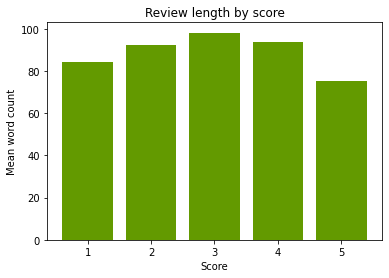

In [9]:
groups = df_cleaned.groupby("Score")

plt.bar(list(map(str, label_values)), list(map(lambda x: np.mean(list(map(lambda y: len(y.split(" ")), x[1].Text.values))), groups)), color=TU_GREEN)
plt.xlabel("Score")
plt.ylabel("Mean word count")
plt.title("Review length by score")

plt.savefig("images/dataset_review_length.pdf")
plt.show()

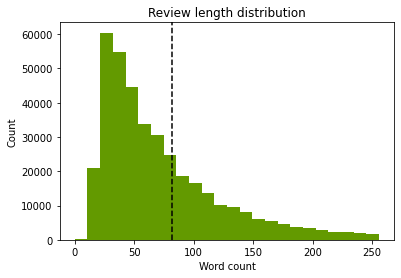

Mean review word count: 81.51 tokens


In [10]:
word_counts = np.array(list(map(lambda x: len(x.split(" ")), df_cleaned.Text.values)))

plt.hist(word_counts, range=(0, 256), bins=24, color=TU_GREEN)
plt.axvline(word_counts.mean(), color="k", linestyle="dashed")

plt.xlabel("Word count")
plt.ylabel("Count")
plt.title("Review length distribution")

plt.savefig("images/dataset_review_length_distribution.pdf")
plt.show()

print("Mean review word count: {:,.2f} tokens".format(word_counts.mean()))